# Portfolio optimization on Dirac
#### Device: Dirac-1


## Introduction

This approach seeks to identify a sub-portfolio of stocks that have superior risk-return profiles compared to the full portfolio. This identifies opportunities for an investor to simplify their investment strategy without sacrificing (and potentially enhancing) the risk-adjusted return. While the expected return on a portfolio is relatively straightforward to optimize by itself, optimizing against risk is more subtle when choosing a set of assets that individually have high returns. The reason that optimizing against risk is more challenging is because asset performances can be correlated. Intuitively, one can see that investing in two highly-correlated assets is more risky than if they are uncorrelated or even anti-correlated. If one of a highly correlated asset is performing poorly, the other in the pair is likely to do so as well. Thus, the variance of a portfolio with both assets can be significantly higher than it would be if they were uncorrelated. Minimizing the overall variance for the return of a portfolio therefore needs to take into account the covariance between the assets, making this a fundamentally quadratic problem, ideal for our Dirac-1 solver.



## Importance

Investments need not only give a good return on average, but also need to balance the potential risks. This balance will depend on the goal of the investor. For example, someone investing their retirement fund is likely to favor modest returns with low risks because the consequences of major losses are severe. On the other hand, someone who is day-trading in the hopes of having more money for entertainment might be willing to take more risks. There are of course many other scenarios with other risk levels. In general, the portfolio optimization problem is viewed as being a multi-objective problem. The goal is to balance the objective of maximizing return with the objective of minimizing risk. Even with multiple objectives there is still a sense of optimality, a portfolio is said to be "efficient" or "[Pareto optimal](https://en.wikipedia.org/wiki/Multi-objective_optimizationy)" if the only ways to decrease risk would be to also decrease return. Regardless of one's appetite for risk, it never makes sense to invest in a non-Pareto-Optimal portfolio, so our goal is to find those that are Pareto optimal and match the appetite for risk which is parameterized by a term  $\xi$ in our description. It is worth noting that this tutorial is based on a relatively simplified but still commonly used model of portfolio optimization. Various efforts exist to take into account more complex structure in the distribution of expected returns, in particular [the failure to capture extreme events](http://math.bu.edu/people/murad/pub/hist11-posted.pdf).

## Applications

Portfolios diversification is necessary to achieve satisfactory outcomes for investors, making the kind of portfolio optimization discussed here (and potentially more complex variants) highly important. In spite of its simplicity, the model of diversification presented here, often referred to as [modern portfolio](https://www.britannica.com/money/modern-portfolio-theory-explained) theory, is [still used](https://www.nutmeg.com/nutmegonomics/markowitzs-legacy-why-modern-portfolio-theory-still). Improvements of the models presented here comprise a subject known as [post-modern portfolio theory](http://actuaries.org/AFIR/Colloquia/Orlando/Ferguson_Rom.pdf). One improvement is to consider a quantity known as [downside risk](https://www.lehigh.edu/~xuy219/research/Downside.pdf) instead of variance. Downside risk only takes into account the risk of portfolio elements underperforming a goal, rather than their total variation. Since the goal of diversification is to protect from risk, this approach can yield better performance.

## Methodology

Let K be the total number of available stocks to choose from (here $K = 253$), that is the size of the stock pool. We want to choose a subset of $K^\prime$  ($K^\prime < K$) stocks such that the portfolio risk is minimized, while the portfolio expected return is maximized, that is

$\min_{\{x_{i}\}_{i \in \{1, 2,..., K\}}} [-E(R)^2 + \xi VAR(R)]$

where $R$ is the daily returns of the portfolio over some period of time, $VAR(R)$ and $E(R)$ are the variance and expectation of daily returns, $\xi$ is a hyper-parameter, and $\{x_{i}\}$ are binary variables representing inclusion or exclusion of a stock. A large value means the focus of optimization is to increase return, whereas a small value indicates the reduction of risk is more important. As we can take both long and short positions on stocks, we assume that $x_1, x_2, ..., x_K$ corresponds to long positions on stocks 1 to $K$. 

As we are choosing a subset of $K^\prime$ stocks, we also need the following constraint,

$\sum_{i=1}^{K} x_i = K^\prime$

Assuming that the same amount is invested on each of the K' selected stocks, the portfolio daily return at time t over a time period denoted by m can be expanded as follows,

$R^{(m)}(t) =\frac{1}{K^\prime} \sum_{i=1}^{K} x_i r^{(m)}_i(t)$

where $r^{(m)}_i(t)$ is the daily return of stock i at time $t$ in time period $m$. The expectation of portfolio daily return over time period $m$ can thus be expanded as,

$E(R^{(m)}) = \frac{1}{K^\prime} \sum_{i=1}^{K} x_i E(r^{(m)}_i)$

and the variance portfolio daily return over time period m is expanded as,

$VAR(R^{(m)}) = \frac{1}{K^{\prime 2}} \sum_{i=1}^{K} \sum_{j=1}^{K} x_i x_j COV(r^{(m)}_i, r^{(m)}_j)$

where $COV$ is the covariant function. 

The problem then reduces to

$\min_{\{x_i\}} {\bf{x}^T} \frac{1}{K^{\prime 2}} [ Q^{(m)} - \xi  P^{(m)}] {\bf{x}}$

where

$Q^{(m)}_{ij} = COV(r^{(m)}_{i},  r^{(m)}_{j})$

$P^{(m)}_{ij}= E(r_i^{(m)}) \delta_{ij}$

To avoid an over-fit on the portfolio data, we can minimize the average of the cost function over $M$ overlapping time periods, that is $m=1,2,...,M$. The problem becomes,

$\min_{\{x_i\}} {\bf{x}^T} \frac{1}{MK^{\prime 2}} \sum_{m=1}^{M}[ Q^{(m)} - \xi  P^{(m)}] {\bf{x}}$

subject to,

$\sum_{i=1}^{K} x_i = K^\prime$


## Implementation

The above-mentioned approach was used to construct an optimal portfolio based on the constituents of the Nasdaq-100 index. The following constituents were used,

In [3]:
import pandas as pd
from IPython.display import display, HTML

df = pd.read_csv("nasdaq100_stocks.csv")

display(HTML(df[["Company", "Symbol"]].to_html()))

,Company,Symbol
0,Microsoft Corp,MSFT
1,Apple Inc,AAPL
2,Amazon.com Inc,AMZN
3,Alphabet Inc,GOOG
4,Alphabet Inc,GOOGL
5,NVIDIA Corp,NVDA
6,Tesla Inc,TSLA
7,Meta Platforms Inc,META
8,PepsiCo Inc,PEP
9,Broadcom Inc,AVGO


We got the historical prices of the constituent stocks, as well as those of Nasdaq-100 (NDX) and equal-weighted Nasdaq-100 (QQQE) using the Yahoo Finance Python library,

In [4]:
# Import libs                                                                                 
import os
import pandas as pd
import yfinance as yf

# Define some parameters                                                                                            
OUT_DIR = "data"
DROP_STOCKS = []

# Get the list of all existing stocks                                                         
stocks = list(df["Symbol"].unique()) + ["NDX", "QQQE"] 

for stock in stocks:
    try:
        tmp_df = yf.Ticker(stock).history(
            period="max", interval="1d",
        )[["Close"]].rename(
            columns={
                "Close": stock,
            }
        )
        tmp_df["Date"] = tmp_df.index
        tmp_df.to_csv(
            os.path.join(OUT_DIR, "%s.csv" % stock),
            index=False,
        )
    except Exception as exc:
        print("Could not get price for %s" % stock)
        print(exc)
        DROP_STOCKS.append(stock)

    if tmp_df.shape[0] == 0:
        DROP_STOCKS.append(stock)

- ATVI: No data found, symbol may be delisted
- SGEN: No data found, symbol may be delisted


Let us import some libraries and set some parameters,

In [5]:
# Import libs                                                                                
import os
import sys
import time
import datetime
import json
import warnings
from functools import wraps
import numpy as np
import pandas as pd

from qci_client import QciClient

warnings.filterwarnings("ignore")

ALPHA = 1.0 # The coefficient for penalty term (for linear constraint)
N_SAMPLES = 20 # Number of solution samples
XI = 5.0 # The xi variable as defined in Methodology
K_PRIME = 30 # Number of selected stocks
WINDOW_DAYS = 30 # Size of each sliding window in days
WINDOW_OVERLAP_DAYS = 15 # Overlap between sliding windows in days
IN_SAMPLE_DAYS = 180 # Size of the lookback period in days
OUT_OF_SAMPLE_DAYS = 30 # Size of the horizon window in days

We now define a function that calculates daily returns of all constituent stocks,

In [6]:
def get_stock_returns(stocks, min_date, max_date):

    min_date = pd.to_datetime(min_date)
    max_date = pd.to_datetime(max_date)
    return_df = None

    for stock in stocks:
        stock_df = pd.read_csv("data/%s.csv" % stock)
        #stock_df["Date"] = stock_df["Date"].astype("datetime64[ns]") # change to fix timezone issue
        stock_df["Date"] = pd.to_datetime([pd.Timestamp(timestamp).date() for timestamp in stock_df["Date"]])  
        stock_df = stock_df.fillna(method="ffill").fillna(method="bfill")
        stock_df[stock] = stock_df[stock].pct_change()
        stock_df = stock_df.dropna()

        stock_df = stock_df[
            (stock_df["Date"] >= min_date) & (stock_df["Date"] <= max_date)
        ]
        
        if return_df is None:
            return_df = stock_df
        else:
            return_df = return_df.merge(stock_df, how="outer", on="Date",)

    return_df = return_df.fillna(method="ffill").fillna(method="bfill")

    return return_df

And a function that calculates the hamiltonian matrix,

In [7]:
def get_hamiltonian(
    return_df, stocks, min_date, max_date,
):

    K = len(stocks)

    # Calculate P and Q                                                                       
    Q = np.zeros(shape=(K, K), dtype="d")
    P = np.zeros(shape=(K, K), dtype="d")
    m = 0
    min_date = pd.to_datetime(min_date)
    max_date = pd.to_datetime(max_date)
    tmp_date = min_date
    while tmp_date <= max_date:
        tmp_min_date = tmp_date
        tmp_max_date = tmp_date + datetime.timedelta(days=WINDOW_DAYS)
        tmp_df = return_df[
            (return_df["Date"] >= tmp_min_date)
            & (return_df["Date"] <= tmp_max_date)
        ]
        r_list = []
        for i in range(K):
            r_list.append(np.array(tmp_df[stocks[i]]))

        Q += np.cov(r_list)

        for i in range(K):
            for j in range(K):
                P[i][j] += np.mean(r_list[i]) * np.mean(r_list[j])

        tmp_date += datetime.timedelta(
            days=WINDOW_DAYS - WINDOW_OVERLAP_DAYS,
        )
        m += 1

    fct = m
    if fct > 0:
        fct = 1.0 / fct

    P = fct * P
    Q = fct * Q

    # Calculate the Hamiltonian                                                              
    H = -P + XI * Q

    # make sure H is symmetric up to machine precision                                       
    H = 0.5 * (H + H.transpose())

    return H

And, we define a function that yields an optimal portfolio given a hamiltonian $H$,

In [ ]:
def optimize_portfolio(H, stocks, curr_date):

    beg_time = time.time()

    K = len(stocks)

    assert H.shape[0] == K
    assert H.shape[1] == K

    # Generate the constraint                                                                
    cons_lhs = np.ones(shape=(K), dtype=np.float32)
    cons_rhs = np.array([-K_PRIME])

    constraints = np.hstack([cons_lhs, cons_rhs])

    # Create json objects   
    objective_json = {
        "file_name": "objective_tutorial_eq_wt_port_opt.json",
        "file_config": {
            "objective": {"data": H, "num_variables": K},
        }  
    }
    
    constraint_json = {
        "file_name": "constraints_tutorial_eq_wt_port_opt.json",
        "file_config": {
            "constraints": {
                "data": constraints, 
                 "num_variables": K,
                 "num_constraints": 1,
            }
        }
    }

    job_json = {
        "job_name": "moodys_eqc1_equal_weights",
        "job_tags": ["moody_nasda100_eqc1_equal_weights",],
        "params": {
            "device_type": "dirac-1",                                             
            "num_samples": N_SAMPLES,
            "alpha": ALPHA,
        },
    }

    # Solve the optimization problem
    token = "<your_secret_token>"
    api_url = "https://api.qci-prod.com"
    qci = QciClient(api_token=token, url=api_url)

    response_json = qci.upload_file(file=objective_json)
    objective_file_id = response_json["file_id"]

    response_json = qci.upload_file(file=constraint_json)
    constraint_file_id = response_json["file_id"]

    job_params = {
        "device_type": "dirac-1", 
        "alpha": ALPHA, 
        "num_samples": N_SAMPLES,
    }
    
    job_json = qci.build_job_body(
        job_type="sample-constraint", 
        job_params=job_params,
        constraints_file_id=constraint_file_id, 
        objective_file_id=objective_file_id,
        job_name=f"tutorial_eqc1",
        job_tags=["tutorial_eqc1"],
    )
    print(job_json)
    
    job_response_json = qci.process_job(
        job_body=job_json
    )

    print(job_response_json)

    results = job_response_json["results"]
    energies = results["energies"]
    samples = results["solutions"]
    is_feasibles = results["feasibilities"]

    # The sample solutions are sorted by energy                                               
    sol = None
    for i, item in enumerate(samples):
        sol = item
        is_feasible = is_feasibles[i]

        if is_feasible:
            break

    if not is_feasible:
        print("Solution is not feasible!")

    assert len(sol) == K, "Inconsistent solution size!"

    if sum(sol) != K_PRIME:
        print(
            "Expected to select %d stocks, but selected %d!"
            % (K_PRIME, sum(sol))
	)

    sel_stocks = []
    for i in range(K):
        if sol[i] > 0:
            sel_stocks.append(stocks[i])

    print(
        "In optimize_portfolio; done with checking constraints; %0.2f seconds!"
        % (time.time() - beg_time)
    )

    return sol, sel_stocks

## Results

We can now test the approach over a period of time, for example, between 2020-01-15 to 2023-12-30. We define,

In [10]:
def run(curr_date):

    print("Processing curr date:", curr_date)

    curr_date = pd.to_datetime(curr_date)
    min_ins_date = curr_date - datetime.timedelta(days=IN_SAMPLE_DAYS)
    max_ins_date = curr_date - datetime.timedelta(days=1)
    min_oos_date = curr_date
    max_oos_date = curr_date + datetime.timedelta(days=OUT_OF_SAMPLE_DAYS)

    df = pd.read_csv("nasdaq100_stocks.csv", low_memory=False)

    stocks = list(set(df["Symbol"]) - set(DROP_STOCKS))

    ins_return_df = get_stock_returns(stocks, min_ins_date, max_ins_date)
    oos_return_df = get_stock_returns(stocks, min_oos_date, max_oos_date)

    ins_return_df = ins_return_df.sort_values("Date")
    ins_return_df = ins_return_df.fillna(method="ffill").fillna(0)

    oos_return_df = oos_return_df.sort_values("Date")
    oos_return_df = oos_return_df.fillna(method="ffill").fillna(0)

    H = get_hamiltonian(ins_return_df, stocks, min_ins_date, max_ins_date)

    sol, sel_stocks = optimize_portfolio(H, stocks, curr_date)

    sel_stock_df = pd.DataFrame()
    sel_stock_df["Date"] = [curr_date] * len(sel_stocks)
    sel_stock_df["Stock"] = sel_stocks

    return sel_stock_df

We can then run a backtest,

In [11]:
min_date = pd.to_datetime("2022-01-13")                                    
max_date = pd.to_datetime("2022-12-30")

SEL_STOCK_OUT_FILE = "selected_stocks.csv"

curr_date = min_date
while curr_date < max_date:
    tmp_sel_stock_df = run(curr_date)

    if os.path.exists(SEL_STOCK_OUT_FILE):
        tmp_sel_stock_df.to_csv(
            SEL_STOCK_OUT_FILE, index=False, mode="a", header=False,
        )
    else:
        tmp_sel_stock_df.to_csv(
            SEL_STOCK_OUT_FILE, index=False,
        )

    curr_date += datetime.timedelta(days=OUT_OF_SAMPLE_DAYS + 1)

    

Processing curr date: 2022-01-13 00:00:00
{'job_submission': {'problem_config': {'quadratic_linearly_constrained_binary_optimization': {'constraints_file_id': '663c2e2f98263204a36575fe', 'objective_file_id': '663c2e2f98263204a36575fc', 'alpha': 1.0}}, 'device_config': {'dirac-1': {'num_samples': 20}}, 'job_name': 'tutorial_eqc1', 'job_tags': ['tutorial_eqc1']}}
2024-05-08 19:00:16 - Dirac allocation balance = 0 s (unmetered)
2024-05-08 19:00:16 - Job submitted: job_id='663c2e30d448b017e54f94d3'
2024-05-08 19:00:16 - QUEUED
2024-05-08 19:00:18 - RUNNING
2024-05-08 19:06:20 - COMPLETED
2024-05-08 19:06:23 - Dirac allocation balance = 0 s (unmetered)
{'job_info': {'job_id': '663c2e30d448b017e54f94d3', 'job_submission': {'job_name': 'tutorial_eqc1', 'job_tags': ['tutorial_eqc1'], 'problem_config': {'quadratic_linearly_constrained_binary_optimization': {'constraints_file_id': '663c2e2f98263204a36575fe', 'objective_file_id': '663c2e2f98263204a36575fc', 'alpha': 1, 'atol': 1e-10}}, 'device_co

We can now calculate the optimal portfolio values over the period of time it was tested.

In [14]:
# Import libs                                                                                 
import sys
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Set params                                                                                  
INIT_PORT_VAL = 1000000.0
OUT_OF_SAMPLE_DAYS = 30
K_PRIME = 30
XI = 5.0
IND_SYMBOL_1 = "QQQE"
IND_SYMBOL_2 = "NDX"

SEL_STOCK_FILE = "selected_stocks.csv"
INDEX_FILE_1 = "data/%s.csv" % IND_SYMBOL_1
INDEX_FILE_2 = "data/%s.csv" % IND_SYMBOL_2

MIN_DATE = pd.to_datetime("2022-01-01")
MAX_DATE = pd.to_datetime("2022-12-31")

# Read allocation file                                                                        
df = pd.read_csv(SEL_STOCK_FILE)
#df["Date"] = df["Date"].astype("datetime64[ns]")
df["Date"] = pd.to_datetime([pd.Timestamp(timestamp).date() for timestamp in df["Date"]])
df = df[(df["Date"] >= MIN_DATE) & (df["Date"] <= MAX_DATE)]

# Loop through dates and calculate port value                                                 
beg_port_val = INIT_PORT_VAL
df = df.sort_values("Date")
adj_dates = sorted(df["Date"].unique())
num_adj_dates = len(adj_dates)
dates = None
port_vals = None
for i in range(num_adj_dates):

    print(
        "Processing adjustment date %s"
        % pd.to_datetime(adj_dates[i]).strftime("%Y-%m-%d")
    )

    beg_date = pd.to_datetime(adj_dates[i])
    if i < num_adj_dates - 1:
        end_date = pd.to_datetime(adj_dates[i + 1])
    else:
        end_date = beg_date + datetime.timedelta(days=OUT_OF_SAMPLE_DAYS)

    tmp_df = df[df["Date"] == beg_date]
    stocks = tmp_df["Stock"]
    stocks = list(set(stocks))

    stocks = list(set(stocks) - set(DROP_STOCKS) - {"FISV"})
    
    if end_date > pd.to_datetime("2023-10-20"):
        stocks = list(set(stocks) - {"ATVI"})

    all_dates = [beg_date]
    date0 = beg_date
    while date0 < end_date:
        date0 = date0 + datetime.timedelta(days=1)
        all_dates.append(date0)

    price_df = pd.DataFrame({"Date": all_dates})

    for stock in stocks:
        stock_df = pd.read_csv("data/%s.csv" % stock)
        #stock_df["Date"] = stock_df["Date"].astype("datetime64[ns]")
        stock_df["Date"] = pd.to_datetime([pd.Timestamp(timestamp).date() for timestamp in stock_df["Date"]])
        stock_df = stock_df[
            (stock_df["Date"] >= beg_date) & (stock_df["Date"] <= end_date)
        ]

        if price_df is None:
            price_df = stock_df
        else:
            price_df = price_df.merge(stock_df, on="Date", how="outer")

    price_df = price_df.fillna(method="ffill").fillna(method="bfill")
    price_df = price_df.sort_values("Date")

    tmp_dates = np.array(price_df["Date"])
    tmp_port_vals = np.zeros(shape=(price_df.shape[0]))

    assert price_df.shape[0] > 0

    for stock in stocks:
        prices = np.array(price_df[stock])
        beg_price = prices[0]
        stock_wt = 1.0 / len(stocks)

        if beg_price <= 0:
            print(stock)
            print(price_df[["Date", stock]])
            
        assert beg_price > 0, "Error in data for %s" % stock # this assertion was failing, when I comment it out we get all NaN values

        stock_count = stock_wt * beg_port_val / beg_price
        tmp_port_vals += stock_count * prices

    if dates is None:
        dates = tmp_dates
    else:
        dates = np.concatenate([dates, tmp_dates])

    if port_vals is None:
        port_vals = tmp_port_vals
    else:
        port_vals = np.concatenate([port_vals, tmp_port_vals])

    beg_port_val = port_vals[-1]

Processing adjustment date 2022-01-13
Processing adjustment date 2022-02-13
Processing adjustment date 2022-03-16
Processing adjustment date 2022-04-16
Processing adjustment date 2022-05-17
Processing adjustment date 2022-06-17
Processing adjustment date 2022-07-18
Processing adjustment date 2022-08-18
Processing adjustment date 2022-09-18
Processing adjustment date 2022-10-19
Processing adjustment date 2022-11-19
Processing adjustment date 2022-12-20


We can then plot the optimal portfolio values and compare them with those of Nasdaq-100 and equal-weighted Nasdaq-100 indexes.

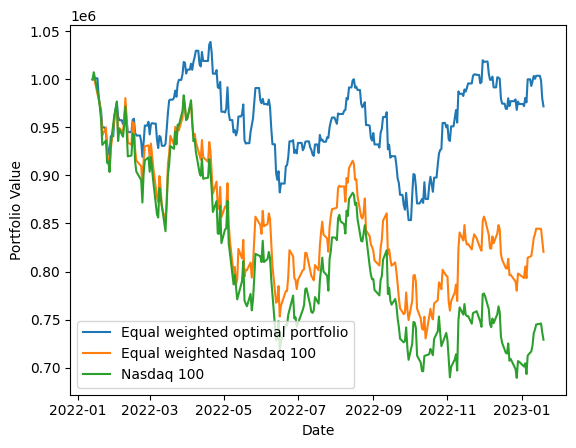

In [15]:
# note these are the results when the beg price assertion from the previous cell was commented, turn into all NaN values
# Plot    
out_df = pd.DataFrame({"Date": dates, "Port_Val": port_vals})
out_df["Date"] = out_df["Date"].astype("datetime64[ns]")
ind_df_1 = pd.read_csv(INDEX_FILE_1)
#ind_df_1["Date"] = ind_df_1["Date"].astype("datetime64[ns]")
ind_df_1["Date"] = pd.to_datetime([pd.Timestamp(timestamp).date() for timestamp in ind_df_1["Date"]])
min_date = out_df["Date"].min()
max_date = out_df["Date"].max()
ind_df_1 = ind_df_1[
    (ind_df_1["Date"] >= min_date) & (ind_df_1["Date"] <= max_date)
]
ind_vals_1 = np.array(ind_df_1[IND_SYMBOL_1])
fct = INIT_PORT_VAL / ind_vals_1[0]
ind_vals_1 *= fct

ind_df_2 = pd.read_csv(INDEX_FILE_2)
#ind_df_2["Date"] = ind_df_2["Date"].astype("datetime64[ns]")
ind_df_2["Date"] = pd.to_datetime([pd.Timestamp(timestamp).date() for timestamp in ind_df_2["Date"]])
min_date = out_df["Date"].min()
max_date = out_df["Date"].max()
ind_df_2 = ind_df_2[
    (ind_df_2["Date"] >= min_date) & (ind_df_2["Date"] <= max_date)
]
ind_vals_2 = np.array(ind_df_2[IND_SYMBOL_2])
fct = INIT_PORT_VAL / ind_vals_2[0]
ind_vals_2 *= fct

plt.plot(
    out_df["Date"], out_df["Port_Val"],                                            
    ind_df_1["Date"], ind_vals_1,
    ind_df_2["Date"], ind_vals_2,
)
plt.xlabel("Date")
plt.ylabel("Portfolio Value")

plt.legend(
    [
        "Equal weighted optimal portfolio",                  
        "Equal weighted Nasdaq 100",
        "Nasdaq 100",
    ]
)                                 
plt.show()

## Conclusion

In this tutorial, we have examined a specific financial application of Dirac related to portfolio optimization. This problem has a naturally quadratic statement, since it relates to minimizing variance of a portfolio based on the covariance between stocks. There is also a natural constraint in the form of the size of the portfolio. 

Like [feature selection](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/feature-selection-on-dirac), [QBoost](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/qboost-for-qubo), and [dimensionality reduction](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/dimensionality-reduction-on-dirac), this tutorial is a variation on the theme of taking advantage of the correlation structure of an underlying data set. Such problems keep arising both because they have important applications, and because they are naturally expressed as QUBOs given the importance of two-body correlations. You may wish to explore other applications of [Quadratic linearly constrained binary optimization](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/qlcbo-on-dirac). Of course you can also get started with your own problems.